# Quiz Vclass M10
- Nama    : Muhamad Ibnu Khaidar Hafiz
- NPM     : 50421867
- Kelas   : 4IA15

Klasifikasi Kucing dan anjing dengan Algoritma Bee Colony

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib
import cv2
import sklearn
import tqdm

print(f'tensorflow version: {tf.__version__}')
print(f'numpy version: {np.__version__}')
print(f'opencv version: {cv2.__version__}')
print(f'matplotlib version: {matplotlib.__version__}')
print(f'sklearn version: {sklearn.__version__}')
print(f'tqdm version: {tqdm.__version__}')

2024-12-03 13:02:37.060819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 13:02:37.085997: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 13:02:37.093961: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 13:02:37.112874: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


tensorflow version: 2.17.0
numpy version: 1.24.4
opencv version: 4.10.0
matplotlib version: 3.7.3
sklearn version: 1.5.2
tqdm version: 4.66.5


In [2]:
!nvidia-smi

Tue Dec  3 13:02:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os

import numpy as np

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

from sklearn.metrics import confusion_matrix, accuracy_score

import random

import cv2

from tqdm import tqdm

In [4]:
# Gunakan GPU jika tersedia
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

I0000 00:00:1733230961.634424   16487 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733230961.646338   16487 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733230961.648424   16487 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [5]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [6]:
DATASET_PATH = 'data/'

In [ ]:
# !pip install kaggle

In [10]:
!chmod 600 /home/ibnuk/algoritma-deep-learning-gundar/tugas6_quizM10/.kaggle/kaggle_API_key.json

In [11]:
# !kaggle datasets download -d tongpython/cat-and-dog

In [12]:
# !unzip cat-and-dog.zip -d data

In [14]:
# Membuat Generator Gambar untuk Data Latih dan Uji
def load_data(img_size=128, batch_size=32):
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_generator = train_datagen.flow_from_directory(
        DATASET_PATH,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        DATASET_PATH,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )

    return train_generator, validation_generator

In [15]:
def build_model(img_size=128):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [16]:
def bee_colony_optimization(model, train_generator, validation_generator, num_bees, max_iterations):
    best_solution = None
    best_accuracy = 0

    bees = [model.get_weights() for _ in range(num_bees)]

    for iteration in range(max_iterations):
        # Fase Lebah Pekerja
        for i in range(num_bees):
            candidate_solution = [b + np.random.uniform(-0.05, 0.05, b.shape) for b in bees[i]]
            model.set_weights(candidate_solution)
            accuracy = evaluate_model(model, validation_generator)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_solution = candidate_solution

        print(f"Iteration {iteration + 1}/{max_iterations}, Best Accuracy: {best_accuracy}")

    # Set solusi terbaik pada model
    model.set_weights(best_solution)
    return model

In [17]:
def evaluate_model(model, validation_generator):
    validation_generator.reset()
    # Predict without specifying steps (let it compute automatically)
    pred = model.predict(validation_generator, verbose=1)

    # Convert predictions to binary labels
    pred = np.where(pred > 0.5, 1, 0)

    # Get ground truth labels
    y_true = validation_generator.classes

    # Ensure consistent lengths
    if len(pred) > len(y_true):
        pred = pred[:len(y_true)]
    elif len(y_true) > len(pred):
        y_true = y_true[:len(pred)]

    # Calculate accuracy
    accuracy = accuracy_score(y_true, pred)
    return accuracy


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_with_confusion_matrix(model, validation_generator):
    validation_generator.reset()
    
    # Predict and handle steps automatically
    pred = model.predict(
        validation_generator,
        steps=validation_generator.samples // validation_generator.batch_size + 1,
        verbose=1
    )

    # Convert predictions to binary
    pred = np.where(pred > 0.5, 1, 0)

    # Get ground truth labels
    y_true = validation_generator.classes

    # Ensure consistent lengths
    if len(pred) > len(y_true):
        pred = pred[:len(y_true)]
    elif len(y_true) > len(pred):
        y_true = y_true[:len(pred)]

    # Compute confusion matrix
    cm = confusion_matrix(y_true, pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return cm


In [19]:
NUM_BEES = 10
MAX_ITERATIONS = 20
LIMIT = 5

In [20]:
img_size = 128
batch_size = 32
train_generator, validation_generator = load_data(img_size=img_size,batch_size=batch_size)
print(f"Number of samples in train_generator: {len(train_generator)}")
print(f"Number of samples in validation_generator: {len(validation_generator)}")
model = build_model(img_size=img_size)

Found 8023 images belonging to 2 classes.
Found 2005 images belonging to 2 classes.
Number of samples in train_generator: 251
Number of samples in validation_generator: 63


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1733230990.133114   16487 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733230990.138027   16487 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733230990.141194   16487 cuda_executor.cc:

In [21]:
optimized_model = bee_colony_optimization(model, train_generator, validation_generator, NUM_BEES, MAX_ITERATIONS)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733230997.305729   16698 service.cc:146] XLA service 0x7fb63c005130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733230997.305783   16698 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-03 13:03:17.321581: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-03 13:03:17.391635: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8904


 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step

I0000 00:00:1733230998.383001   16698 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
Iteration 1/20, Best Accuracy: 0.798503740648379
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
Iteration 2/20, Best Accuracy: 0.798503740648379
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
63/63 ━━━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
Confusion Matrix:
[[   0  404]
 [   1 1600]]


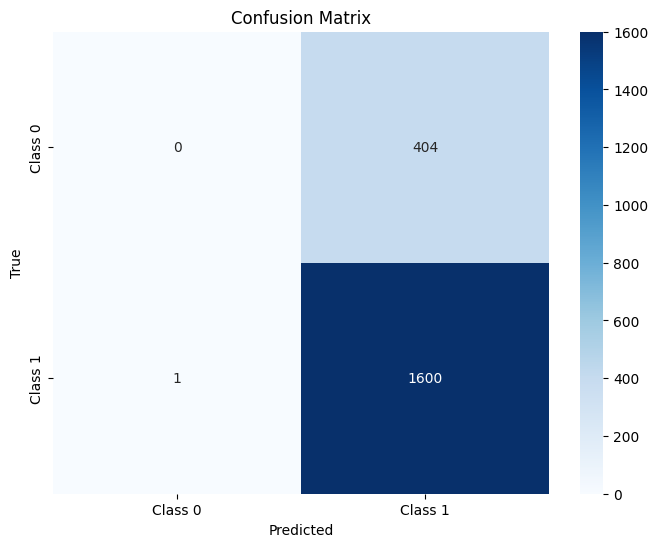

array([[   0,  404],
       [   1, 1600]])

In [22]:
evaluate_with_confusion_matrix(optimized_model, validation_generator)